# ARIMA

Все хотят знать, что же будет дальше с экономикой. Из-за этого люди активно придумывают и строят всякие индикаторы, которые должны помочь понять, когда начнётся кризис. В этом задании вам предстоит проанализировать несколько подобных индикаторов и выяснить правда ли они улучшают прогнозы. 

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns

from matplotlib import pyplot as plt
plt.style.use('ggplot')

%matplotlib inline

# 1. Краткая история

__Про ручные индексы__

Экономисты хотят понимать насколько сильно люди верят в прекрасное экономическое будущее. Для этого они проводят социальные опросы: просят оценить насколько люди доверяют банкам, спрашивают есть ли у них инвестиции в ценные бумаги и тп. В итоге ответы на эти вопросы превращаются в индекс потребительских настроений. 

Первым такую штуку начал делать Мичиганский университет. Он спрашивает $500$ потребителей. Каждому задаёт $5$ вопросов, касающихся их финансового положения и мнения о нынешнем состоянии (2 вопроса) и будущем (3 вопроса) экономики. Берется процентная доля респондентов, отметивших улучшение экономических условий, из нее вычитается доля тех, кто заявил, что стало хуже, к полученному числу прибавляется 100. Из ответов на первые 2 вопроса формируется обзор нынешнего экономического положения, из последних $3$-х — индекс потребительских ожиданий. Таким образом, ожидания отвечают примерно за $60\%$ индекса. Расчёт индекса делается дважды в месяц.

В России по аналогичной методике "Левада-центр" начал считать свой индекс потребительских натсроений. На его динамику даже можно посмотреть [у них на сайте.](https://www.levada.ru/indikatory/sotsialno-ekonomicheskie-indikatory/) На самом деле, сейчас социологи считают довольно много подобных индексов. Тот же самый [PMI (индекс деловой активности)](https://ru.wikipedia.org/wiki/Индекс_деловой_активности) - один из возможных вариантов. 

Такие индексы можно пытаться использовать для того, чтобы улучшить прогнозы разных макроэкономических рядов вроде безработицы. И люди активно пытаются это делать. Проблема заключается в том, что нужно тратить много ресурсов на то, чтобы сделать социальный опрос. Плюс социальные опросы можно делать редко. Хочется, чтобы было быстро, дёшево и часто.

__Про автоматические индексы__

Выход есть. Нужно заглянуть в интернет. Любая поисковая система собирает статистику, связанную с запросами пользователей. Более того, частично такая статистика [находится в открытом доступе.](https://trends.google.ru/trends/?geo=RU) Это позволяет собирать информацию о том, чем интересовались люди и на её основе делать какие-то выводы.

Например, в 2013 году Google заявил, что с помощью информации из поисковых запросов о трейлерах, он может с низкой MAPE предсказывать кассовость ленты в первые дни показа. Поисковые запросы используют для предсказания распространения эпидемий гриппа и даже ковида.

По аналогии можно узнать, чем люди интересуются во время кризиса, а дальше попытаться отслеживать такие запросы и понимать, насколько сильно колеблется их обеспокоенность. 

# 2. Данные 

В табличке ниже вам даны несколько индексов потребительских настроений и несколько переменных для прогнозирования: 

- `levada_IPN` - индекс потребительских настроений, который строится на основе социальных опросов Левада-центром. Отражает то, насколько сильно люди доверяют экономике.
- `poiskInd_corr`- индекс поиска, отражает то, насколько сильно люди обеспокоенны тем, что происходит с экономикой. Он построен на основе поисковых запросов. Как именно - для задания неважно, но подробнее об этом можно почитать [в статье про подобные индексы.](https://rjmf.econs.online/2020/4/forecasting-macroeconomic-indicators-news-and-search-queries/)

- `USD` - динамика курса доллара
- `RTRD` - оборот розничной торговли (текущие цены, млрд. рублей)

In [3]:
df = pd.read_csv('data/data.tsv', sep='\t')
df.set_index('fielddate', inplace=True)
print(df.shape)
df.head()

(194, 4)


,poiskInd_corr,RTRD,levada_IPN,USD
fielddate,,,,
2004-01-01,3.455561,396.5,NaN,28.838795
2004-02-01,9.761241,397.4,NaN,28.514674
2004-03-01,16.271264,433.6,NaN,28.529262
2004-04-01,18.356332,435.6,NaN,28.685632
2004-05-01,10.663158,435.7,NaN,28.989217


выбросим все стоки с пропусками и будем рассматривать индексы на одном и том же временном промежутке. 

In [4]:
df.dropna(inplace=True)

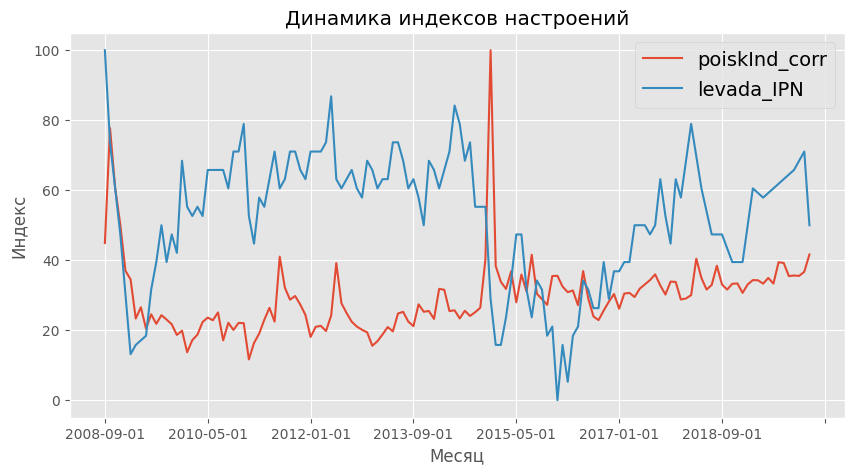

In [5]:
df[['poiskInd_corr', 'levada_IPN']].plot(figsize=(10,5));

plt.title('Динамика индексов настроений');
plt.xlabel("Месяц")
plt.ylabel("Индекс")
plt.legend(fontsize=14);

Видно, что в период кризиса индекс доверия Левады падает. Индекс обеспокоенности, построенный по гуглу, растёт. 

# 3. Предварительный анализ рядов

Проанализируем динамику валютного курса и оборота розничной торговли более детально.

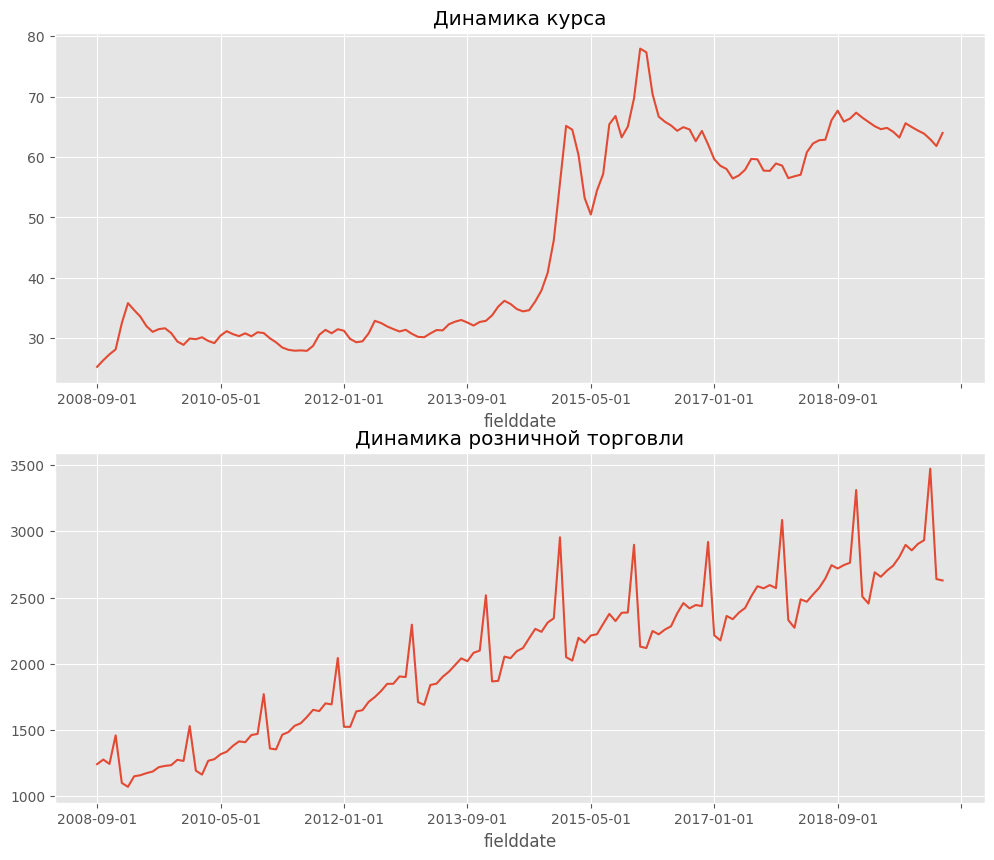

In [6]:
_, axes = plt.subplots(2, 1, figsize=(12,10))

df['USD'].plot(ax=axes[0]);
df['RTRD'].plot(ax=axes[1]);

axes[0].set_title("Динамика курса")
axes[1].set_title("Динамика розничной торговли");

- Видим, что динамика валютного курса нестационарна. У нас есть два математических ожидания. В динамике ряда нет ни тренда ни сезонности.
- В динамике розничной торговли есть тренд и сезонность.  

__[а] Проверьте гипотезу о стационарности рядов с помощью KPSS и ADF тестов на уровне значимости $5\%$. В качестве ответа в переменнык `pval` запишите соотвествующие p-value.__ Обратите внимание, что в динамике розничной торговли есть константа и тренд. В динамике курса есть константа.

In [8]:
from statsmodels.tsa.stattools import adfuller, kpss

### ╰( ͡° ͜ʖ ͡° )つ▬▬ι═══════  bzzzzzzzzzz
# will the code be with you

pval_usd_kpss = ...
pval_rtrd_kpss = ...

pval_usd_adf = ...
pval_rtrd_adf = ...


# your code here


USD KPSS p-value: 0.0100
RTRD KPSS p-value: 0.0100
USD ADF p-value: 0.7791
RTRD ADF p-value: 0.3853


C:\Users\zaits\AppData\Local\Temp\ipykernel_27796\1870360352.py:7: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_usd = kpss(df['USD'], regression='c', nlags='auto')
C:\Users\zaits\AppData\Local\Temp\ipykernel_27796\1870360352.py:14: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_rtrd = kpss(df['RTRD'], regression='ct', nlags='auto')


In [9]:
assert np.abs(pval_usd_kpss - 0.01) < 1e-2
assert np.abs(pval_usd_adf - 0.77) < 1e-2

# несколько похожих скрытых тестов

Оба ряда оказались на уровне значимости $5\%$ нестационарными по всем тестам. 

__[б]__ Возьмите первую разность от валютного курса методом `.diff()`. Для оборота розничной торговли возьмите $12$-ую, сезонную разность. Изобразите динамику разностей на картинке. 

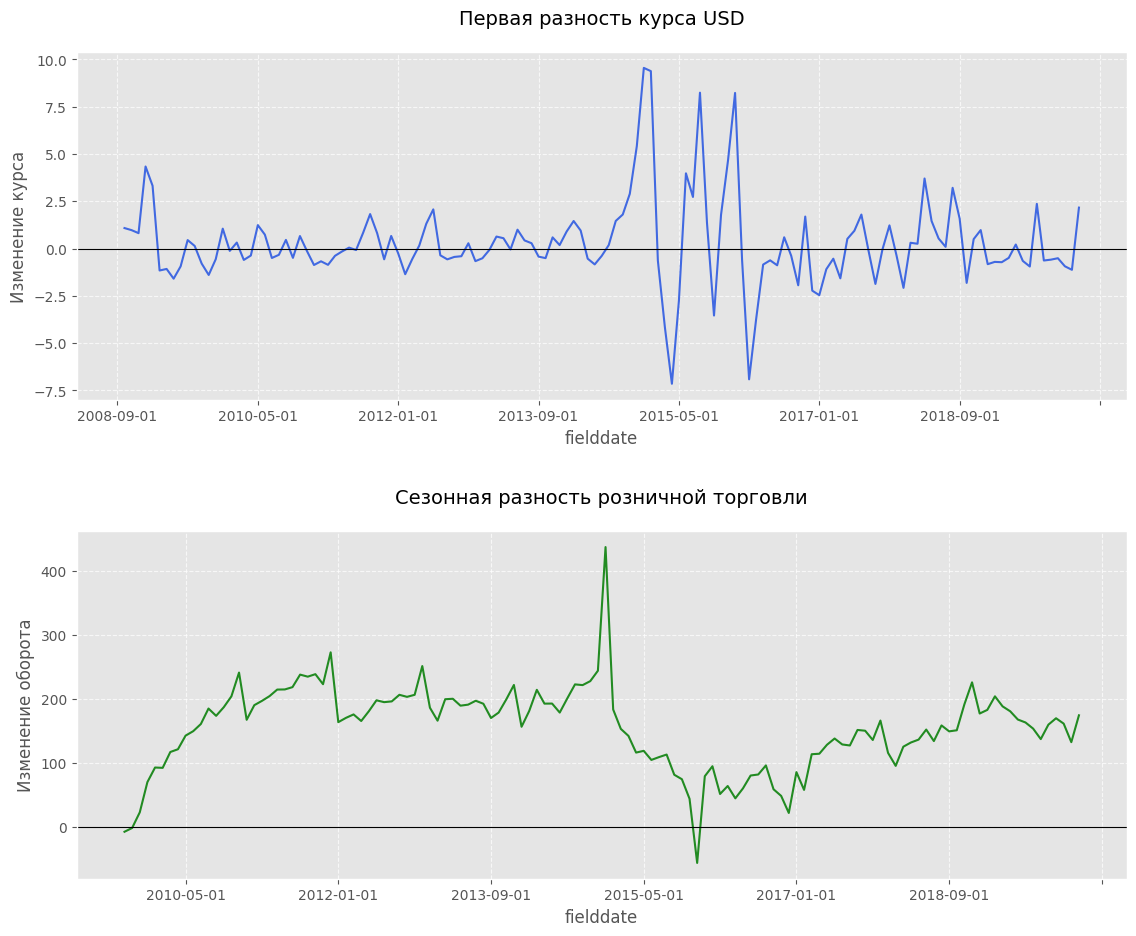

In [13]:
### ╰( ͡° ͜ʖ ͡° )つ▬▬ι═══════  bzzzzzzzzzz
# will the code be with you

# your code here
df['USD_diff'] = df['USD'].diff(1)
df['RTRD_diff12'] = df['RTRD'].diff(12)

plt.rcParams['figure.figsize'] = (12, 10)

fig, (ax1, ax2) = plt.subplots(2, 1)
# График первой разности USD
df['USD_diff'].plot(ax=ax1, color='royalblue', linewidth=1.5)
ax1.set_title('Первая разность курса USD', fontsize=14, pad=20)
ax1.set_ylabel('Изменение курса', fontsize=12)
ax1.grid(True, linestyle='--', alpha=0.7)
ax1.axhline(0, color='black', linestyle='-', linewidth=0.8)
df['RTRD_diff12'].plot(ax=ax2, color='forestgreen', linewidth=1.5)
ax2.set_title('Сезонная разность розничной торговли', fontsize=14, pad=20)
ax2.set_ylabel('Изменение оборота', fontsize=12)
ax2.grid(True, linestyle='--', alpha=0.7)
ax2.axhline(0, color='black', linestyle='-', linewidth=0.8)
plt.tight_layout(pad=3.0)
plt.show()

Проверьте ADF-тестом гипотезу о стационарности рядов на уровне значимости $5\%$. В соотвествующие переменные запишите `pvalue` тестов. Обратите внимание, что для курса у нас нет ни константы, ни тренда. Для оборота торговли есть константа.

In [15]:
### ╰( ͡° ͜ʖ ͡° )つ▬▬ι═══════  bzzzzzzzzzz
# will the code be with you


# your code here
adf_usd = adfuller(df['USD_diff'].dropna(), regression='n')
pval_diff_usd = adf_usd[1]
adf_rtrd = adfuller(df['RTRD_diff12'].dropna(), regression='c')
pval_diff_rtrd = adf_rtrd[1]
print(f"p-value для разности USD: {pval_diff_usd}")
print(f"p-value для сезонной разности RTRD: {pval_diff_rtrd}")

p-value для разности USD: 1.650774482648531e-14
p-value для сезонной разности RTRD: 0.03684914819183372


In [16]:
assert pval_diff_usd < 1e-10

# несколько похожих скрытых тестов

Для обоих рядов гипотеза о наличии единичного корня отвергается. 

> Посмотрим внимательнее на динамику разностей валютного курса. Возникает ощущение, что в конце $2014$ - $2015$ годах дисперися валютного курса была больше, чем в другие периоды времени. Это связано с [валютным кризисом](https://ru.wikipedia.org/wiki/Валютный_кризис_в_России_(2014—2015)) и тем, что с этого момента ЦБ сфокусировался на таргетировании инфляции. Такой разброс в дисперсии будет приводить к тому, что предпосылки ARIMA-модели не будут выполняться. Из-за этого будут портиться доверительные интервалы. Можно стабилизировать дисперсию преобразованием Бокса-Кокса.

__[в]__ Обучите на исходном ряде для курса преобразование Бокса-Кокса, если подзабыли что это за преобразование, пересмотрите лекцию про это из самого первого курса :) Возьмите первые разности, нарисуйте ряд на картинке, стала ли ситуация с дисперсией визуально лучше?

In [22]:
!pip3 install pmdarima

Defaulting to user installation because normal site-packages is not writeable
  Using cached pmdarima-2.0.4.tar.gz (630 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Using cached cython-3.1.0-cp313-cp313-win_amd64.whl.metadata (31 kB)
Using cached cython-3.1.0-cp313-cp313-win_amd64.whl (2.7 MB)
Failed to build pmdarima


  error: subprocess-exited-with-error
  
  exit code: 1
  
  [43 lines of output]
  Partial import of pmdarima during the build process.
  
  Requirements: ['joblib>=0.11\nCython>=0.29,!=0.29.18,!=0.29.31\nnumpy>=1.21.2\npandas>=0.19\nscikit-learn>=0.22\nscipy>=1.3.2\nstatsmodels>=0.13.2\nurllib3\nsetuptools>=38.6.0,!=50.0.0\npackaging>=17.1  # Bundled with setuptools, but want to be explicit\n']
  Adding extra setuptools args
  Setting up with setuptools
  Traceback (most recent call last):
    File "C:\Users\zaits\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 389, in <module>
      main()
      ~~~~^^
    File "C:\Users\zaits\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 373, in main
      json_out["return_va

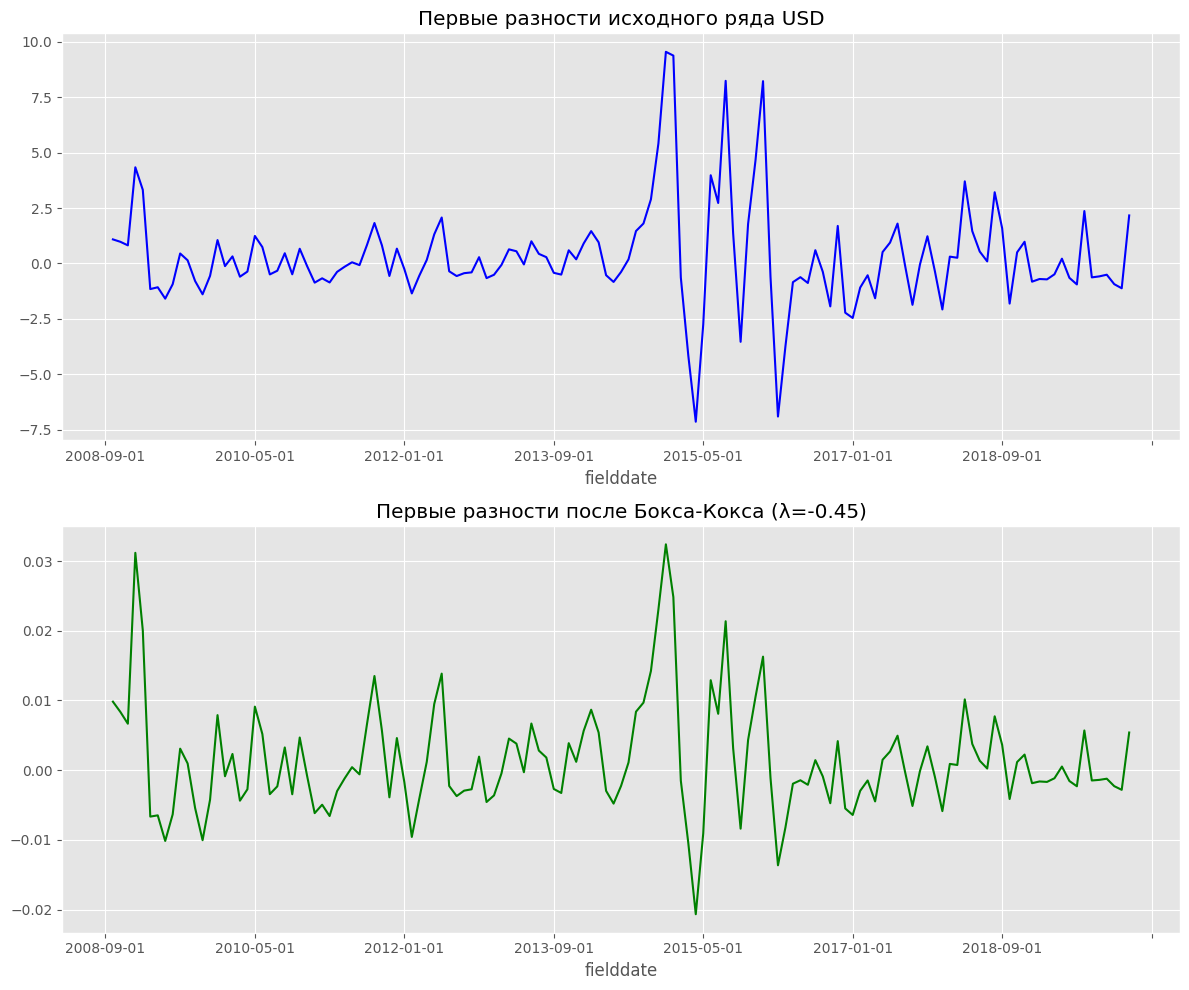

Стандартное отклонение исходных разностей: 2.2822
Стандартное отклонение после преобразования: 0.0078


In [26]:
# import pmdarima as pm
# from pmdarima.preprocessing import BoxCoxEndogTransformer

### ╰( ͡° ͜ʖ ͡° )つ▬▬ι═══════  bzzzzzzzzzz
# will the code be with you

# your code here
from scipy.stats import boxcox

usd_values = df['USD'].dropna() + 1e-6
usd_boxcox, lmbda = boxcox(usd_values)

temp_df = pd.DataFrame({
    'USD': usd_values,
    'USD_boxcox': usd_boxcox
}, index=usd_values.index)

temp_df['USD_diff'] = temp_df['USD'].diff()
temp_df['USD_boxcox_diff'] = temp_df['USD_boxcox'].diff()
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
temp_df['USD_diff'].plot(ax=ax1, color='blue')
ax1.set_title('Первые разности исходного ряда USD')
ax1.grid(True)
temp_df['USD_boxcox_diff'].plot(ax=ax2, color='green')
ax2.set_title(f'Первые разности после Бокса-Кокса (λ={lmbda:.2f})')
ax2.grid(True)
plt.tight_layout()
plt.show()

print(f"Стандартное отклонение исходных разностей: {temp_df['USD_diff'].std():.4f}")
print(f"Стандартное отклонение после преобразования: {temp_df['USD_boxcox_diff'].std():.4f}")

In [27]:
assert np.abs(transformer.lam1_ + 0.447) < 1e-3

# Тут нет скрытых тестов :)

NameError: name 'transformer' is not defined

Добавил аналогичный ассерт, так как не смог импортировать библиотеку. Использовал scipy.stats для этих целей

In [30]:
assert np.abs(lmbda + 0.447) < 1e-3

# 4. ARIMA-модель

Разобьём выборку на тренировочную и тестовую, а затем обучим ARIMA-модель. 

1. Параметры `p,q` перебирайте от 0 до 5 включительно, `P,Q` от 1 до 3
2. Параметр `seasonal` выставите в `true` с `m=12`
3. Параметры `max_D, max_d` потавьте равными 2
4. Парааметр `max_order` выставите в 10
5. В поле `information_criterion` выберите для выбора моделя критерий Шварца (`bic`)

In [ ]:
import pmdarima as pm

def train_arima(y, test_size=36):
    y_train, y_test = y[:-test_size], y[-test_size:]

    arima_model = pm.auto_arima(
        y_train,

        start_p=0, start_q=0, max_p=5, max_q=5,
        start_P=1, start_Q=1, max_P=3, max_Q=3,
        seasonal=True, m=12,
        max_D=2, max_d=2,
        max_order=10,
        information_criterion='bic',

        trace=True)

    arima_model.fit(y_train)

    return arima_model

Запустите код для обучения. Обратите внимание, что перебираться будут не все модели. Так происходит из-за того, что в опциях модели выставлено `stepwise=True`. Это специальный алгоритм для более быстрого перебора гипер-параметров. Его разработали в 2008 годую. Подробнее [в документации.](https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html)

In [ ]:
model_rtrd = train_arima(df.RTRD.values)

In [ ]:
model_usd = train_arima(df.USD.values)

In [ ]:
model_rtrd.summary()

In [ ]:
model_usd.summary()

Запишите в переменные`ans1` и `ans2` порядок $AR$ и $MA$ частей лучшей модели для оборот арозничной торговли. В переменные `ans3` и `ans4` запишите аналогичный результат для валютного курса. 

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ▬▬ι═══════  bzzzzzzzzzz
# will the code be with you
ans1 = ...
ans2 = ...
ans3 = ...
ans4 = ...

# your code here


In [ ]:
assert ans1 == 0

# несколько похожих скрытых тестов

Постройте протоколы для диагностики получившихся моделей. __Устно ответьте на вопросы:__ всё ли нормально с остатками? Можно ли использовать эти модели для прогнозирования? А для строительства доверительных интервалов? 

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ▬▬ι═══════  bzzzzzzzzzz
# will the code be with you

# your code here


Внимательно изучите код, написанный ниже. Он строит Leave One Out прогнозы. Сначала обучение идёт на `y_train`. Прогноз строится на один период вперёд. Затем одно наблюдение из `y_test` добавляется в `y_train` и та же модель обучается на новой выборке. Прогноз строится ещё на одно наблюдение вперёд. Так продолжается до тех пор, пока не кончится выборка `y`. 

In [ ]:
from pmdarima import model_selection

def mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def loo_cv(model, y, test_size=36):
    
    y_train, y_test = y[:-test_size], y[-test_size:]

    # метод, который строит прогнозы по заданному внутри правилу
    cv = model_selection.SlidingWindowForecastCV(
        window_size=y_train.size,   # начинаем с трейновой выборки 
        step=1,                     # шаг между фолдами для обучения 
        h=1                         # на сколько шагов вперёд каждый раз строить прогноз
    )

    predicts_noIndex = model_selection.cross_val_predict(
        model, y, # идём получившейся arima_model по y 
        cv = cv,        # по правилам, заданным выше строим прогнозы 
    )
    
    return predicts_noIndex, mae(y_test, predicts_noIndex)

Используя функцию, написсанную выше, постройте прогнозы для курса доллара и оборота розничной торговли. Замерьте качество получившихся прогнозов с помощью метрики MAE. Запишите получившиеся результаты в переменные `mae_usd` и `mae_rtrd`.

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ▬▬ι═══════  bzzzzzzzzzz
# will the code be with you

# your code here


Изобразите получившиеся прогнозы и исходный ряд на одной картинке. Можно попрбовать использовать для этого функцию `plot_series` из пакет `sktime`. Не забудьте установить его в своё текущее локальное окружение по аналогии с тем, как ммы это сделали для предыдущей домашней работы. 

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ▬▬ι═══════  bzzzzzzzzzz
# will the code be with you

# your code here


> __ВАЖНО!!!__ Перед отправкой тетрадки в грейдер на оценивание закомментируйте код, который обучает модели. Оставьте только ответы, записанные в соотвествующие переменные. При выставлении оценки ваш код должен отрабатывать за 30 секунд. Из-за того, что модель обучается довольно долго, полноценный код процедуру тестирования не пройдёт.

# 5. ARIMA с экзогенными переменными

Теперь давайте добавим в качестве экзогенной переменной в нашу модель лаги индексов неопределённости. Если бы у нас была модель $ARMA(1,1)$ и мы бы захотели добавить в неё экзогенную переменную $x_{t-1}$, модель выглядела бы так:

$$
y_t = \mu + \beta \cdot  y_{t-1} + \alpha \cdot \varepsilon_{t-1} + \varepsilon_t + \gamma \cdot x_{t-1} 
$$

Экзогенных переменных можно добавить сколько угодно. Для этого у модели есть отдельный параметр. Он на вход принимает матрицу. Для удобства всю процедуру оценки модели завернём в функцию. Внимательно изучите, чем именно эта функция отличается от предыдущей. 

In [ ]:
def loo_cv_with_index(model, y, x, test_size=36):
    
    y_train, x_train = y[:-test_size], x[:-test_size]    
    y_test, x_test = y[-test_size:], x[-test_size:]

    cv = model_selection.SlidingWindowForecastCV(
        window_size=y_train.size, 
        step=1, 
        h=1
    )

    predicts = model_selection.cross_val_predict(
        model, y,
        exogenous = np.array([x]).T,
        cv=cv
    )
    
    return predicts, mae(y_test, predicts)

Лучшую модель мы подобрали. Давайте попробуем добавить в неё в качестве экзогенной переменной наши индексы неопределённости. Это поможет нам увидеть, правда ли эти индексы улучшают качество прогнозов.

### Оборот розничной торговли

Добавим текущее значение индекса. Если качество прогноза вырасте, это означает, что текущий индекс содержит в себе информацию о том, что произошло в экономике прямо сейчас. Для прогнозирования это бесполезно, но показывает насколько сильно наш индекс может объяснить ситуацию в экономике.

> Код ниже может работать довольно долго. 

In [ ]:
y = df.RTRD.values
x = df.levada_IPN.values

predicts_levada_rtrd, mae_rtrd_2 = loo_cv_with_index(model_rtrd, y, x)

In [ ]:
y = df.RTRD.values
x = df.poiskInd_corr.values

predicts_poisk_rtrd, mae_rtrd_3 = loo_cv_with_index(model_rtrd, y, x)

In [ ]:
print(f'Оригинальная модель: {mae_rtrd}')
print(f'Модель с индексом Левады: {mae_rtrd_2}')
print(f'Модель с индексом поиска: {mae_rtrd_3}')

Индекс Левады улучшил прогноз оборота розничной торговли. Индекс поиска ухудшил. Попробуем посмотреть, получится ли у нас предсказывать по текущему значению индекса будущее значение оборота розничной торговли.

In [ ]:
y = df.RTRD.values[1:]
x = df.levada_IPN.shift(1).values[1:] # shift это сдвиг на 1 вперёд, мы же предсказываем лагом

predicts_levada_rtrd, mae_rtrd_2 = loo_cv_with_index(model_rtrd, y, x)

In [ ]:
y = df.RTRD.values[1:]
x = df.poiskInd_corr.shift(1).values[1:] # shift это сдвиг на 1 вперёд, мы же предсказываем лагом

predicts_poisk_rtrd, mae_rtrd_3 = loo_cv_with_index(model_rtrd, y, x)

In [ ]:
print(f'Оригинальная модель: {mae_rtrd}')
print(f'Модель с индексом Левады: {mae_rtrd_2}')
print(f'Модель с индексом поиска: {mae_rtrd_3}')

Видно, что оба индекса ухудшили прогнозы :( 

###  Курс валюты 

Проделаем такую же операцию с валютным курсом. 

In [ ]:
y = df.USD.values
x = df.levada_IPN.values

predicts_levada_usd, mae_usd_2 = loo_cv_with_index(model_usd, y, x)

In [ ]:
y = df.USD.values
x = df.poiskInd_corr.values

predicts_poisk_usd, mae_usd_3 = loo_cv_with_index(model_usd, y, x)

In [ ]:
print(f'Оригинальная модель: {mae_usd}')
print(f'Модель с индексом Левады: {mae_usd_2}')
print(f'Модель с индексом поиска: {mae_usd_3}')

Видго, что оба индекса содержат информацию о том, какие значения курс принял прямо сейчас. Попробуем посмотреть, можно ли прогнозировать курс с помощью запаздывания лучше, чем обычной ARIMA. 

In [ ]:
y = df.USD.values[1:]
x = df.levada_IPN.shift(1).values[1:] # shift это сдвиг на 1 вперёд, мы же предсказываем лагом

predicts_levada_usd, mae_usd_2 = loo_cv_with_index(model_usd, y, x)

In [ ]:
y = df.USD.values[1:]
x = df.poiskInd_corr.shift(1).values[1:] # shift это сдвиг на 1 вперёд, мы же предсказываем лагом

predicts_poisk_usd, mae_usd_3 = loo_cv_with_index(model_usd, y, x)

In [ ]:
print(f'Оригинальная модель: {mae_usd}')
print(f'Модель с индексом Левады: {mae_usd_2}')
print(f'Модель с индексом поиска: {mae_usd_3}')

Видно, что индекс поиска улучшил прогнозы. Индекс Левады не привёл к улучшению. 

__Выводы:__ индексы поиска и Левады содержут информацию о том, что в данный момент происходит в экономике. Их текущее значение помогает предсказать, что происходит прямо сейчас в экономике. На практике это бесполезно. Мы хотим по вчерашнему значению индекса спрогнозировать, что произойдет завтра. Видно, что это можно сделать для курса доллара с помощью индекса поиска.

Обратите внимание, что данные у нас месячные. Если бы частота данных была бы повыше, эффект от добавления индексов в модели мог бы быть сильнее. Но это требует отдельного исследования :) 

Попробуйте, по аналогии с тем, что было сделано выше, добавить в модель в качестве экзогенных переменных сразу оба индекса. Насколько сильно это улучшает прогноз? 

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ▬▬ι═══════  bzzzzzzzzzz
# will the code be with you

> __ВАЖНО!!!__ Перед отправкой тетрадки в грейдер на оценивание закомментируйте код, который обучает модели. Оставьте только ответы, записанные в соотвествующие переменные. При выставлении оценки ваш код должен отрабатывать за 30 секунд. Из-за того, что модель обучается довольно долго, полноценный код процедуру тестирования не пройдёт.

# Бонусный трэк:

- Попробуйте взять в качестве дополнительных экзогенных переменных сразу же и индекс поиска и индекс Левада-центра. 
- Выше мы сказали, что у валютного курса не самая стабильная дисперсия. Соберите пайплайн, в котором первым шагом метод Бокса-Кокса будет стабилизировать дисперсию. Обучите обе модели и посмотрите что происходит с качеством прогнозов. 
- По картинкам для диагностики модели видно, что в данных есть выброс. Можно попробовать изолировать его с помощью экзогенной дамми-переменной, если хочется добиться идеального выполнения предпосылок. 
- Если вас заинтересовали индексы неопределённости, можно посмотреть [статью про такие индексы](https://github.com/FUlyankin/uncertainty_index)

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ▬▬ι═══════  bzzzzzzzzzz
# will the code be with you